# Benchmarking Pipeline: Compare Baseline vs DWF Model
This notebook compares a fixed-incentive strategy against the DWF RL model using cancellation rate, incentives, and profitability.

In [37]:
# Load Libraries
import gymnasium as gym
from gymnasium import Env, spaces
import pandas as pd
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import VecNormalize
from scipy.special import expit
import os

In [38]:
train_df = pd.read_csv("datasets/train_split.csv")
val_df =  pd.read_csv("datasets/val_split.csv")

In [ ]:
class RideHailingEnv_DWF(Env):
    def __init__(self, df):
        super(RideHailingEnv_DWF, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_idx = 0
        self.episode_limit = 1000
        self.episode_start = 0

        self.observation_space = spaces.Box(low=0, high=1, shape=(8,), dtype=np.float32)
        self.action_space = spaces.Box(
            low=np.array([-0.15, 0.0]),
            high=np.array([0.15, 5.0]),
            dtype=np.float32
        )

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_idx = np.random.randint(0, len(self.df) - self.episode_limit)
        self.episode_start = self.current_idx
        return self._get_observation(), {}

    def step(self, action):
        if self.current_idx >= len(self.df) - 1 or (self.current_idx - self.episode_start >= self.episode_limit):
            obs = self._get_observation()
            done = True
            reward = 0.0
            self.episode_start = self.current_idx + 1
            return obs, reward, done, False, {"CR": 0.5}

        row = self.df.iloc[self.current_idx]
        fare_adjustment, rider_incentive = np.round(action, 2)
        t_i = row['Request to Pickup']
        base_fare = row.get('Base Fare', 10.0)
        delta = 0.2 * base_fare

        # --- Behavior-based features
        rank_percentile = (self.df['Request to Pickup'] < t_i).sum() / len(self.df)
        epsilon = np.random.normal(loc=0.0, scale=0.02)
        RPI = np.clip(1.0 - rank_percentile + epsilon, 0.0, 1.0)

        # Amplify the impact of actions using exponential DPI
        action_signal = rider_incentive + abs(fare_adjustment * base_fare)
        DPI = np.clip(1.0 - np.exp(-0.6 * action_signal) + epsilon, 0.0, 1.0)

        # CR: stronger dependency on DPI (action-driven cancellation)
        cr_input = 1.2 * rank_percentile - 1.3 * RPI - 2.0 * DPI
        CR = 1.0 / (1.0 + np.exp(-cr_input))
        ride_completed = CR < 0.5

        # === Reward Components
        base_reward = 1.5 * (1.0 - CR)             # Completion-focused reward

        cost = rider_incentive + abs(fare_adjustment) * delta
        cost_ratio = cost / (base_fare + 5)
        cost_penalty = 0.5 * max(cost_ratio - 0.2, 0.0)  # Penalty only after 20%

        efficiency_bonus = 0.2 if ride_completed and cost_ratio < 0.2 else 0.0

        reward = base_reward - cost_penalty + efficiency_bonus
        reward = np.clip(reward, -2.0, 2.0)

        self.current_idx += 1
        done = False
        obs = self._get_observation()

        return obs, reward, done, False, {
            "CR": CR,
            "RPI": RPI,
            "DPI": DPI,
            "cost": cost,
            "base_reward": base_reward,
            "cost_penalty": cost_penalty
        }



    def _get_observation(self):
        if self.current_idx >= len(self.df):
            return np.zeros(self.observation_space.shape, dtype=np.float32)
        row = self.df.iloc[self.current_idx]
        return np.array([
            row['Pickup Location'],
            row['Request to Pickup'],
            row['Time of Day'],
            row['Month of Year'],
            row['RPI'],
            row['DPI'],
            row['CR'],
            row['Historical Demand Forecast']
        ], dtype=np.float32)


In [ ]:
# Baseline 1 Model
class RideHailingEnv_Feature_Baseline(RideHailingEnv_DWF):
    def __init__(self, df):
        super().__init__(df)
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
    
    def _get_observation(self):
        row = self.df.iloc[self.current_idx]
        return np.array([
            row['Pickup Location'],
            row['Request to Pickup'],
            row['Time of Day'],
            row['Month of Year'],
        ], dtype=np.float32)


# Baselie_2 Model
class RideHailingEnv_Cost_Baseline(RideHailingEnv_DWF):
    def __init__(self, df):
        super().__init__(df)
        self.observation_space = spaces.Box(low=0, high=1, shape=(8,), dtype=np.float32)

    
    def step(self, action):
        if self.current_idx >= len(self.df) - 1 or (self.current_idx - self.episode_start >= self.episode_limit):
            obs = self._get_observation()
            done = True
            reward = 0.0
            self.episode_start = self.current_idx + 1
            return obs, reward, done, False, {"CR": 0.5}

        row = self.df.iloc[self.current_idx]
        fare_adjustment, rider_incentive = np.round(action, 2)
        t_i = row['Request to Pickup']
        base_fare = row.get('Base Fare', 10.0)

        # === Basic ride cancellation model without synthetic features ===
        rank_percentile = (self.df['Request to Pickup'] < t_i).sum() / len(self.df)
        epsilon = np.random.normal(loc=0.0, scale=0.02)

        # Simplified CR estimation: no RPI/DPI, only wait time percentile
        cr_input = 1.2 * rank_percentile + epsilon
        CR = 1.0 / (1.0 + np.exp(-cr_input))
        ride_completed = CR < 0.5

        # === Reward: purely focused on maximizing ride completions ===
        reward = 1.0 if ride_completed else -1.0

        self.current_idx += 1
        done = False
        obs = self._get_observation()

        return obs, reward, done, False, {
            "CR": CR,
            "cost": 0.0,
            "base_reward": reward,
            "cost_penalty": 0.0,
            "RPI": None,
            "DPI": None
        }


In [42]:
def train_variant(env_cls, train_df, val_df, model_name):
    # Train environment
    train_env = DummyVecEnv([lambda: env_cls(train_df)])
    train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True)

    # Validation environment
    val_env = DummyVecEnv([lambda: env_cls(val_df)])
    val_env = VecNormalize(val_env, training=False, norm_obs=True, norm_reward=False)

    # Evaluation callback
    eval_callback = EvalCallback(
        val_env,
        best_model_save_path=f"./logs/{model_name}/",
        log_path=f"./logs/{model_name}/",
        eval_freq=5000,
        deterministic=True,
        render=False
    )

    model = PPO(
        "MlpPolicy",
        train_env,
        tensorboard_log=f"./ppo_tensorboard_logs/{model_name}/",
        learning_rate=1e-4,
        n_steps=2048,
        batch_size=256,
        gamma=0.98,
        gae_lambda=0.95,
        clip_range=0.4,
        ent_coef=0.01,
        vf_coef=0.8,               # boost critic learning slightly
        max_grad_norm=0.5,
        n_epochs=15,
        policy_kwargs=dict(net_arch=[64, 64]),
        verbose=1,
        device="cuda"
    )

    model.learn(total_timesteps=78000, callback=eval_callback)

    model.save(f"models/{model_name}")
    train_env.save(f"models/{model_name}_vecnormalize.pkl")


In [43]:
train_variant(RideHailingEnv_Feature_Baseline, train_df, val_df, "model_feature_base")

Using cuda device


c:\anaconda\envs\analysis\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Logging to ./ppo_tensorboard_logs/model_feature_base/PPO_1
-----------------------------
| time/              |      |
|    fps             | 241  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 271          |
|    iterations           | 2            |
|    time_elapsed         | 15           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0022560577 |
|    clip_fraction        | 0.000163     |
|    clip_range           | 0.4          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -0.874       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.226        |
|    n_updates            | 15           |
|    policy_gradient_loss | -0.00198     |
|    std                  | 0.999        |


c:\anaconda\envs\analysis\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=1035.11 +/- 1.47
Episode length: 1001.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 1e+03        |
|    mean_reward          | 1.04e+03     |
| time/                   |              |
|    total_timesteps      | 5000         |
| train/                  |              |
|    approx_kl            | 0.0036868267 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.4          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -0.266       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.0736       |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00255     |
|    std                  | 1            |
|    value_loss           | 0.263        |
------------------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps   

In [47]:
train_variant(RideHailingEnv_Cost_Baseline, train_df, val_df, "model_cost_base")

Using cuda device
Logging to ./ppo_tensorboard_logs/model_cost_base/PPO_1
-----------------------------
| time/              |      |
|    fps             | 359  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 332          |
|    iterations           | 2            |
|    time_elapsed         | 12           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0027326543 |
|    clip_fraction        | 0.000163     |
|    clip_range           | 0.4          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -0.771       |
|    learning_rate        | 0.0001       |
|    loss                 | 1.17         |
|    n_updates            | 15           |
|    policy_gradient_loss | -0.00241     |
|    std                  | 

Benchmarking

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
import numpy as np

def compute_score(avg_cost, avg_cr, alpha=0.6, beta=0.4):
    return alpha * avg_cost + beta * avg_cr

def evaluate_model(model_path, vecnormalize_path, env_class, test_df):
    env = DummyVecEnv([lambda: Monitor(env_class(test_df))])
    vec_norm = VecNormalize.load(vecnormalize_path, env)
    vec_norm.training = False
    vec_norm.norm_reward = False

    model = PPO.load(model_path)

    obs = vec_norm.reset()
    total_cost = 0
    total_revenue = 0
    completed_rides = 0
    total_cr = 0
    num_steps = 0

    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_norm.step(action)
        info = info[0]

        cr = info.get("CR", 0.5)
        total_cr += cr
        is_completed = cr < 0.5
        if is_completed:
            completed_rides += 1

        fare_adjustment, rider_incentive = np.round(action[0], 2)
        base_fare = test_df.iloc[num_steps].get("Base Fare", 10.0)
        delta = 0.2 * base_fare
        fare = base_fare + fare_adjustment * base_fare
        cost = rider_incentive + abs(fare_adjustment) * delta

        total_cost += cost

        num_steps += 1
        if num_steps >= len(test_df) or done:
            break

    avg_cr = total_cr / num_steps
    avg_cost = total_cost / num_steps
    score = compute_score(avg_cost, avg_cr)

    return {
        "avg_cost": avg_cost,
        "avg_cr": avg_cr,
        "score": score,
        "total_steps": num_steps
    }


In [49]:
test_df = pd.read_csv("datasets/test_split.csv")

In [ ]:
results = {}

model_variants = {
    "Feature Base": (
        "models/model_feature_base.zip",
        "models/model_feature_base_vecnormalize.pkl",
        RideHailingEnv_Feature_Baseline
    ),
    "DWF": (
        "models/dwf_model.zip",
        "models/dwf_vecnormalize.pkl",
        RideHailingEnv_DWF
    ),
    "Cost Base": (
        "models/model_cost_base.zip",
        "models/model_cost_base_vecnormalize.pkl",
        RideHailingEnv_Cost_Baseline
    ),
}

for name, (model_path, vecnorm_path, env_class) in model_variants.items():
    print(f"Evaluating: {name}")
    results[name] = evaluate_model(model_path, vecnorm_path, env_class, test_df)
    print(f" → Completed {results[name]['total_steps']} steps | "
          f"CR: {results[name]['avg_cr']:.3f} | "
          f"Cost: {results[name]['avg_cost']:.3f} | "
          f"Revenue: {results[name]['avg_revenue']:.3f} | "
          f"Score: {results[name]['score']:.3f}")


Evaluating: Feature Base
 → Completed 1001 steps | CR: 0.226 | Cost: 0.586 | Revenue: 11.730 | Score: 0.442
Evaluating: DWF
 → Completed 1001 steps | CR: 0.227 | Cost: 0.485 | Revenue: 11.244 | Score: 0.382
Evaluating: Cost Base
 → Completed 1001 steps | CR: 0.647 | Cost: 0.553 | Revenue: 0.063 | Score: 0.590


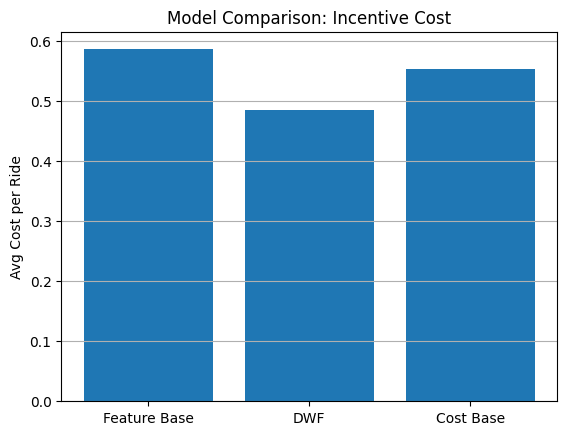

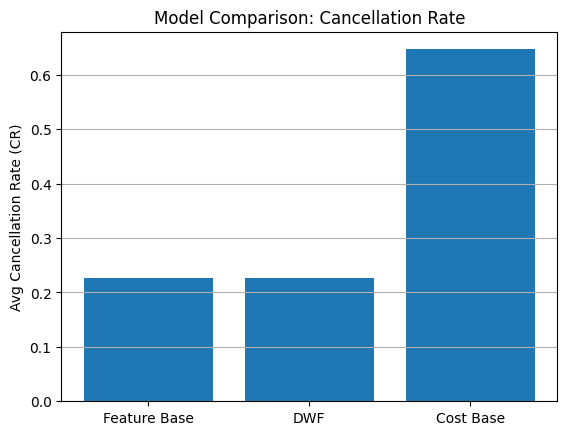

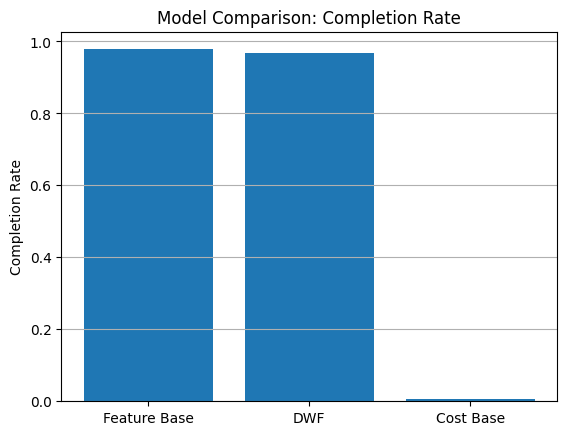

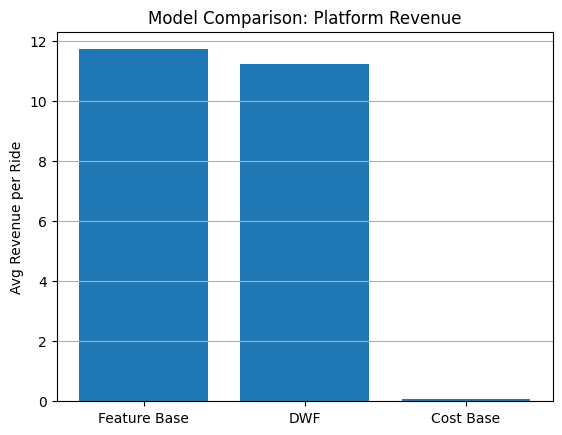

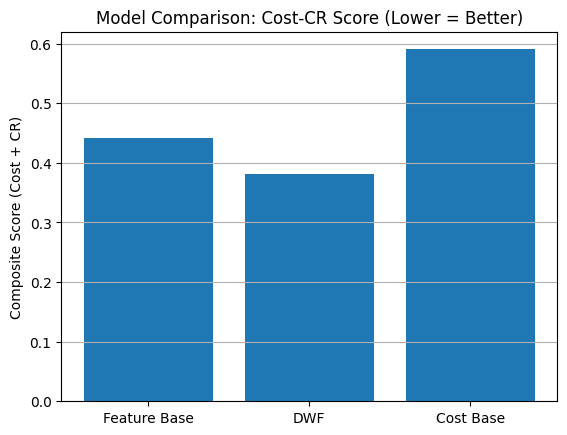

In [ ]:
import matplotlib.pyplot as plt

labels = list(results.keys())
avg_costs = [results[k]["avg_cost"] for k in labels]
completion_rates = [results[k]["completion_rate"] for k in labels]
cancel_rates = [results[k]["avg_cr"] for k in labels]
avg_revenues = [results[k]["avg_revenue"] for k in labels]
scores = [results[k]["score"] for k in labels]

# Plot 1: Avg Incentive Cost per Ride
plt.figure()
plt.bar(labels, avg_costs)
plt.ylabel("Avg Cost per Ride")
plt.title("Model Comparison: Incentive Cost")
plt.grid(axis='y')
plt.show()

# Plot 2: Average Cancellation Rate (CR)
plt.figure()
plt.bar(labels, cancel_rates)
plt.ylabel("Avg Cancellation Rate (CR)")
plt.title("Model Comparison: Cancellation Rate")
plt.grid(axis='y')
plt.show()

# Plot 5: Custom Composite Score (Lower = Better)
plt.figure()
plt.bar(labels, scores)
plt.ylabel("Composite Score (Cost + CR)")
plt.title("Model Comparison: Cost-CR Score (Lower = Better)")
plt.grid(axis='y')
plt.show()
